### Conditional GAN for CIFAR-10 with Visuals, Gradio, and Confusion Matrix

**Cell 1: Imports and Global Configuration**

This cell sets up all the necessary libraries and global parameters for the GAN.

In [3]:
# !pip install gradio
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from IPython import display # For clear_output in Colab/Jupyter
import glob # For GIF creation
import imageio # For GIF creation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # For confusion matrix
import gradio as gr # For the interactive interface

# --- Global lists to store losses for plotting ---
generator_losses = []
discriminator_losses = []

# Global variable for number of classes
num_classes = 10 # CIFAR-10 has 10 classes

# --- Training Parameters ---
EPOCHS = 100 # You might need more epochs for better results on CIFAR-10
noise_dim = 100 # Dimension of the latent space (random noise vector)
num_examples_to_generate = 16 # Number of images to generate for visualization

# CIFAR-10 class names for Gradio interface and plotting
cifar10_class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

**Cell 2: Data Loading and Preprocessing Function**

This cell defines the function to load and normalize the CIFAR-10 dataset.

In [4]:
def load_and_prepare_dataset():
    """Loads and preprocesses the CIFAR-10 dataset."""
    print("Loading CIFAR-10 dataset...")
    (train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

    # CIFAR-10 images are 32x32x3 (color)
    # Reshape and normalize to [-1, 1]
    train_images = train_images.astype('float32')
    train_images = (train_images - 127.5) / 127.5 # Normalize to [-1, 1]

    # One-hot encode labels
    train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
    train_labels = train_labels.astype('float32')

    BUFFER_SIZE = 50000 # CIFAR-10 train set size
    BATCH_SIZE = 80 # Adjusted batch size, you can experiment

    # Create a dataset of (image, label) pairs
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    print("Dataset loaded and prepared.")
    return train_dataset, BATCH_SIZE

**Cell 3: Generator Model Definition**

This cell contains the function to define the architecture of the Conditional Generator.

In [5]:
def make_generator_model(noise_dim, num_classes):
    """Defines the Conditional Generator network architecture for 32x32x3 images."""
    noise_input = layers.Input(shape=(noise_dim,), name='noise_input')
    label_input = layers.Input(shape=(num_classes,), name='label_input')

    # Concatenate noise and label inputs
    merged_input = layers.concatenate([noise_input, label_input])
    x = layers.Dense(4*4*512, use_bias=False)(merged_input) # Initial dense layer mapping to 4x4x512
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Reshape((4, 4, 512))(x) # Reshape to 4x4 spatial dimensions

    # Transpose Convolutional Layers to upsample to 32x32
    # Conv2DTranspose 1: 4x4x512 -> 8x8x256
    x = layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Conv2DTranspose 2: 8x8x256 -> 16x16x128
    x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Conv2DTranspose 3: 16x16x128 -> 32x32x64
    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Output layer: 32x32x3 (for color images)
    # Use tanh activation for output in [-1, 1] range
    output_image = layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)

    model = tf.keras.Model(inputs=[noise_input, label_input], outputs=output_image, name='Generator')
    return model

**Cell 4: Discriminator Model Definition**

This cell contains the function to define the architecture of the Conditional Discriminator.

In [6]:
def make_discriminator_model(num_classes):
    """Defines the Conditional Discriminator network architecture for 32x32x3 images."""
    image_input = layers.Input(shape=[32, 32, 3], name='image_input') # Input shape for CIFAR-10 images
    label_input = layers.Input(shape=(num_classes,), name='label_input')

    # Expand label to match image dimensions for concatenation
    label_embedding = layers.Dense(32 * 32 * 1)(label_input) # Map label to a 32x32x1 feature map
    label_embedding = layers.Reshape((32, 32, 1))(label_embedding)

    # Concatenate image and label embedding along the channel axis
    merged_input = layers.concatenate([image_input, label_embedding]) # Resulting shape: (None, 32, 32, 4)

    # Convolutional Layers to downsample
    # Conv2D 1: 32x32x4 -> 16x16x64
    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(merged_input) # Input channels changed to 4
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    # Conv2D 2: 16x16x64 -> 8x8x128
    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    # Conv2D 3: 8x8x128 -> 4x4x256
    x = layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    output_score = layers.Dense(1)(x) # Output a single score (real/fake)

    model = tf.keras.Model(inputs=[image_input, label_input], outputs=output_score, name='Discriminator')
    return model

**Cell 5: Loss Functions and Optimizers**

This cell defines the loss functions and sets up the Adam optimizers for both models.

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    """Calculating the discriminator's loss."""
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    """Calculates the generator's loss."""
    # The generator wants the discriminator to classify fake images as real (label 1)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# --- ADJUSTED LEARNING RATES ---
# It's common to have the discriminator learn a bit slower
generator_optimizer = tf.keras.optimizers.Adam(1e-4) # Learning rate 0.0001
discriminator_optimizer = tf.keras.optimizers.Adam(5e-5) # Learning rate 0.00005 (half of generator's)

2025-06-15 11:56:27.888171: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


**Cell 6: Training Step and Helper Functions (Image Generation, Plots, GIF, Confusion Matrix)**

This cell contains the `train_step` function (the core of one GAN update) and helper functions for generating/saving images, plotting losses, creating GIFs, and the *new* function for plotting the Discriminator's confusion matrix.

In [8]:
# This seed will be used for consistent evaluation image generation.
# We'll create fixed noise and fixed labels for this seed.
fixed_eval_noise = tf.random.normal([num_examples_to_generate, noise_dim])

# Create fixed labels for evaluation, cycling through all 10 classes
fixed_eval_labels = tf.concat([tf.one_hot([i % num_classes for i in range(num_examples_to_generate)], num_classes)], axis=0)


@tf.function
def train_step(images, labels):
    # """Performs one training step for both generator and discriminator."""
    batch_size_actual = tf.shape(images)[0] # Get actual batch size, as last batch might be smaller
    noise = tf.random.normal([batch_size_actual, noise_dim])

    # Generate random labels for fake images within the batch
    # This ensures the generator learns to produce images for various classes
    random_labels_for_generator = tf.one_hot(tf.random.uniform([batch_size_actual], minval=0, maxval=num_classes, dtype=tf.int32), num_classes)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, random_labels_for_generator], training=True)

        real_output = discriminator([images, labels], training=True) # Pass real images and their labels
        fake_output = discriminator([generated_images, random_labels_for_generator], training=True) # Pass fake images and the labels they were generated with

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_output, fake_output # Return outputs for confusion matrix


def generate_and_save_images(model, epoch, test_noise, test_labels, save_dir='./generated_images'):
    # """Generates and saves sample images based on given noise and labels."""
    predictions = model([test_noise, test_labels], training=False)
    predictions = (predictions * 127.5 + 127.5).numpy().astype(np.uint8) # Denormalize for display

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :]) # Display 3-channel image
        plt.axis('off')

    plt.savefig(f'{save_dir}/image_at_epoch_{epoch:04d}.png')
    plt.close(fig)

def plot_losses(gen_losses, disc_losses, save_path='./training_metrics/gan_losses.png'):
    # """Plots generator and discriminator losses over training epochs."""
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path))

    plt.figure(figsize=(10, 6))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Conditional GAN Training Losses Over Epochs (CIFAR-10)')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    # plt.close()
    plt.show()
    print(f"Loss plot saved to {os.path.abspath(save_path)}")


def plot_discriminator_confusion_matrix(real_outputs, fake_outputs, epoch, save_dir='./training_metrics'):
    # """
    # Plots the confusion matrix for the discriminator's performance (real vs. fake).
    # Real images are 'Positive' (label 1), Fake images are 'Negative' (label 0).
    # """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Convert logits to binary predictions (0 or 1)
    real_preds = tf.cast(real_outputs > 0, tf.int32) # Discriminator predicts real if logit > 0
    fake_preds = tf.cast(fake_outputs <= 0, tf.int32) # Discriminator predicts fake if logit <= 0

    # True labels: 1 for real, 0 for fake
    y_true = tf.concat([tf.ones_like(real_preds), tf.zeros_like(fake_preds)], axis=0).numpy()
    # Predicted labels: from discriminator's output
    y_pred = tf.concat([real_preds, fake_preds], axis=0).numpy()

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1]) # labels=[0, 1] ensures order
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])

    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    ax.set_title(f'Discriminator Confusion Matrix (Epoch {epoch})')
    plt.savefig(f'{save_dir}/disc_confusion_matrix_epoch_{epoch:04d}.png')
    plt.close(fig)
    plt.show()
    # print(f"Discriminator confusion matrix saved for Epoch {epoch}")


def generate_interpolation_map(generator_model, noise_dim, num_classes, num_steps=8, save_path='./generated_images/interpolation_map.png'):
    # """
    # Generates a grid of images showing interpolation in the latent space
    # for a specific class.
    # """
    z1 = tf.random.normal([1, noise_dim])
    z2 = tf.random.normal([1, noise_dim])

    # Example: always generate class 0 ('airplane')
    fixed_label_for_interp = tf.one_hot(tf.constant([0]), num_classes)
    fixed_labels_batch = tf.repeat(fixed_label_for_interp, repeats=[num_steps], axis=0)

    interpolation_vectors = []
    for i in range(num_steps):
        alpha = i / (num_steps - 1)
        interpolated_z = (1 - alpha) * z1 + alpha * z2
        interpolation_vectors.append(interpolated_z)

    interpolation_noise_batch = tf.concat(interpolation_vectors, axis=0)

    interpolated_images = generator_model([interpolation_noise_batch, fixed_labels_batch], training=False)
    interpolated_images = (interpolated_images * 127.5 + 127.5).numpy().astype(np.uint8)

    fig = plt.figure(figsize=(num_steps, 1))
    for i in range(interpolated_images.shape[0]):
        plt.subplot(1, num_steps, i + 1)
        plt.imshow(interpolated_images[i, :, :, :])
        plt.axis('off')

    plt.suptitle(f"Latent Space Interpolation (Class 0, Generated Images: {num_steps})", y=1.05)
    plt.savefig(save_path, bbox_inches='tight')
    plt.close(fig)
    print(f"Latent space interpolation map saved to {os.path.abspath(save_path)}")

def create_gif_from_images(image_dir, gif_name):
    """Creates a GIF from saved generated images."""
    print("Creating GIF from generated images...")
    anim_file = os.path.join(image_dir, gif_name)
    filenames = glob.glob(os.path.join(image_dir, 'image_at_epoch_*.png'))
    filenames = sorted(filenames)

    images = []
    for filename in filenames:
        try:
            images.append(imageio.imread(filename))
        except Exception as e:
            print(f"Could not read image {filename}: {e}")
            continue

    if images:
        try:
            imageio.mimsave(anim_file, images, fps=10, loop=0) # loop=0 makes it loop indefinitely
            print(f"GIF saved to {os.path.abspath(anim_file)}")
        except Exception as e:
            print(f"Error creating GIF: {e}")
    else:
        print("No images found to create GIF.")

**Cell 7: Main Training Loop**

This cell defines the `train` function, which orchestrates the entire training process over multiple epochs. It now calls the confusion matrix plotting function.

In [9]:
# Cell 7: Main Training Loop

def train(dataset, epochs):
    """Main training loop for the Conditional GAN."""
    global generator_losses, discriminator_losses # Declare global to modify the lists

    metrics_dir = './training_metrics'
    if not os.path.exists(metrics_dir):
        os.makedirs(metrics_dir)

    print(f"Starting training for {epochs} epochs...") # This will print once at the start
    for epoch in range(epochs):
        start = time.time()

        epoch_gen_loss_avg = tf.keras.metrics.Mean()
        epoch_disc_loss_avg = tf.keras.metrics.Mean()

        # Lists to accumulate real and fake outputs for confusion matrix
        all_real_outputs = tf.TensorArray(tf.float32, size=0, dynamic_size=True, element_shape=tf.TensorShape([None, 1]))
        all_fake_outputs = tf.TensorArray(tf.float32, size=0, dynamic_size=True, element_shape=tf.TensorShape([None, 1]))
        idx = 0

        for image_batch, label_batch in dataset:
            gen_loss, disc_loss, real_output, fake_output = train_step(image_batch, label_batch)
            epoch_gen_loss_avg(gen_loss)
            epoch_disc_loss_avg(disc_loss)

            # Accumulate outputs for confusion matrix
            all_real_outputs = all_real_outputs.write(idx, real_output)
            all_fake_outputs = all_fake_outputs.write(idx, fake_output)
            idx += 1

        generator_losses.append(epoch_gen_loss_avg.result().numpy())
        discriminator_losses.append(epoch_disc_loss_avg.result().numpy())

        # Removed display.clear_output(wait=True) here
        # This will ensure all epoch prints are displayed sequentially

        # Use the fixed evaluation noise and labels for consistent image generation
        generate_and_save_images(generator, epoch + 1, fixed_eval_noise, fixed_eval_labels)

        # Plot confusion matrix at the end of each epoch
        plot_discriminator_confusion_matrix(all_real_outputs.concat(), all_fake_outputs.concat(), epoch + 1, metrics_dir)

        print(f'Epoch {epoch + 1}, '\
              f'Gen Loss: {epoch_gen_loss_avg.result():.4f}, '\
              f'Disc Loss: {epoch_disc_loss_avg.result():.4f}, '\
              f'Time: {time.time()-start:.2f} sec')

    # Removed display.clear_output(wait=True) here as well
    # This ensures the final epoch's print remains visible before completion messages
    generate_and_save_images(generator, epochs, fixed_eval_noise, fixed_eval_labels) # Save final images
    print("Training complete!")
    print(f"Generated images saved in the '{os.path.abspath('./generated_images')}' directory.")
    print(f"Training metrics (losses, confusion matrices) saved in the '{os.path.abspath(metrics_dir)}' directory.")

    plot_losses(generator_losses, discriminator_losses)
    generate_interpolation_map(generator, noise_dim, num_classes, num_steps=8)
    create_gif_from_images(image_dir='./generated_images', gif_name='cgan_cifar10_training_progress.gif')

**Cell 8: Main Execution Block (Setup Models and Start Training)**

This is where you execute the data loading, model instantiation, summary printing, and kick off the training.

In [10]:
# --- Execute the GAN training ---
#

train_dataset, BATCH_SIZE = load_and_prepare_dataset()

# Create generator and discriminator instances
generator = make_generator_model(noise_dim, num_classes)
discriminator = make_discriminator_model(num_classes)



Loading CIFAR-10 dataset...


2025-06-15 11:56:35.513304: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.


Dataset loaded and prepared.


**Cell 9: Generate Specific Images (After Training)**

After the training in Cell 8 completes, you can use this cell to test generating images of specific classes.

In [11]:
# Print model summaries
print("\n--- Generator Model Summary ---")
generator.summary()


--- Generator Model Summary ---


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ noise_input         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_input         │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 110)       │          0 │ noise_input[0][0… │
│ (Concatenate)       │                   │            │ label_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8192)      │    901,120 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 8192)      │     32,768 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 8192)      │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 4, 4, 512) │          0 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 8, 8, 256) │  3,276,800 │ reshape[0][0]     │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ conv2d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 8, 8, 256) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 16, 16,    │    819,200 │ leaky_re_lu_1[0]… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 32, 32,    │    204,800 │ leaky_re_lu_2[0]… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 32, 32, 3) │      4,800 │ leaky_re_lu_3[0]… │
│ (Conv2DTranspose)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 5,241,280 (19.99 MB)

 Trainable params: 5,224,000 (19.93 MB)

 Non-trainable params: 17,280 (67.50 KB)

In [12]:
print("\n--- Discriminator Model Summary ---")
discriminator.summary()


--- Discriminator Model Summary ---


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input         │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1024)      │     11,264 │ label_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 32, 32, 1) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32, 4) │          0 │ image_input[0][0… │
│ (Concatenate)       │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │      6,464 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 16, 16,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ leaky_re_lu_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 128) │    204,928 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 8, 8, 128) │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 8, 128) │          0 │ leaky_re_lu_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 256) │    819,456 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 4, 4, 256) │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 4, 4, 256) │          0 │ leaky_re_lu_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4096)      │          0 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,046,209 (3.99 MB)

 Trainable params: 1,046,209 (3.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Start training
print("\n--- Starting GAN Training ---")
train(train_dataset, EPOCHS)


--- Starting GAN Training ---
Starting training for 100 epochs...


2025-06-15 11:56:39.189049: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.



--- Generating specific class images ---


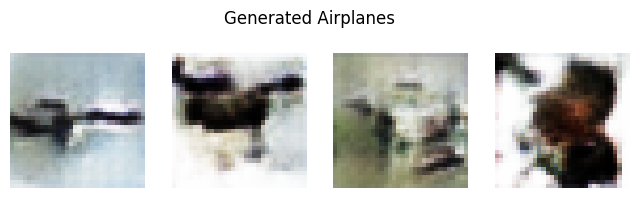

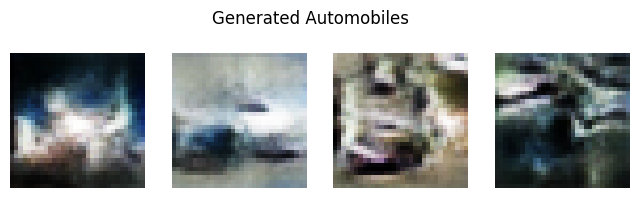

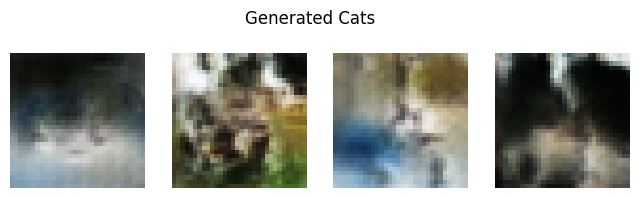

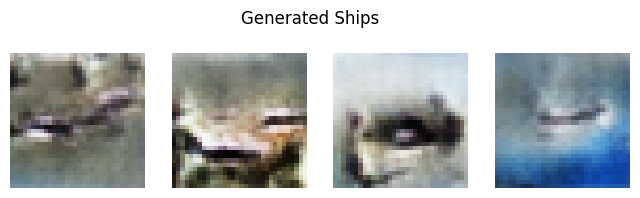

In [ ]:
# --- Example: Generate images of a specific class using the trained Generator ---
# This cell can be run after the training in Cell 8 has finished.

print("\n--- Generating specific class images ---")
def generate_specific_class_image_plot(generator_model, noise_dim, target_class_index, num_to_generate=4):
    """Generates and displays images for a specific class."""
    noise = tf.random.normal([num_to_generate, noise_dim])
    target_labels = tf.one_hot([target_class_index] * num_to_generate, num_classes)

    predictions = generator_model([noise, target_labels], training=False)
    predictions = (predictions * 127.5 + 127.5).numpy().astype(np.uint8)

    plt.figure(figsize=(num_to_generate * 2, 2))
    for i in range(num_to_generate):
        plt.subplot(1, num_to_generate, i + 1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')
    plt.suptitle(f"Generated {cifar10_class_names[target_class_index].capitalize()}s", y=1.05)
    plt.show()

# --- Run examples for different classes ---
generate_specific_class_image_plot(generator, noise_dim, target_class_index=0) # Airplanes
generate_specific_class_image_plot(generator, noise_dim, target_class_index=1) # Automobiles
generate_specific_class_image_plot(generator, noise_dim, target_class_index=3) # Cats
generate_specific_class_image_plot(generator, noise_dim, target_class_index=8) # Ships

**Cell 10: Gradio Interface for Interactive Generation**

This new cell sets up and launches a Gradio interface. Run this *after* training is complete to interact with your trained GAN.

In [ ]:

def generate_image_for_gradio(class_name, noise_seed):

    # Map class name string to its index
    try:
        target_class_index = cifar10_class_names.index(class_name.lower())
    except ValueError:
        return "Invalid class name. Please choose from: " + ", ".join(cifar10_class_names)

    # Use the seed for reproducible noise
    tf.random.set_seed(noise_seed)
    noise = tf.random.normal([1, noise_dim]) # Generate one image
    tf.random.set_seed(None) # Reset seed for general randomness

    target_label = tf.one_hot([target_class_index], num_classes)

    # Generate image using the trained generator
    generated_image = generator([noise, target_label], training=False)

    # Denormalize and convert to uint8 for display
    generated_image = (generated_image.numpy()[0] * 127.5 + 127.5).astype(np.uint8)

    return generated_image

# Set up Gradio interface
iface = gr.Interface(
    fn=generate_image_for_gradio,
    inputs=[
        gr.Dropdown(cifar10_class_names, label="Select Class"),
        # FIX: Changed 'default' to 'value'
        gr.Slider(minimum=0, maximum=1000, step=1, value=42, label="Noise Seed (for reproducibility)")
    ],
    outputs=gr.Image(label="Generated Image", type="numpy"),
    title="Conditional GAN Image Generator (CIFAR-10)",
    description="Generate CIFAR-10-like images by selecting a class and a noise seed."
)

print("\n--- Launching Gradio Interface ---")
# To run this in Google Colab, use share=True
# To run locally, share=False (default)
iface.launch(share=True) # Set share=True to get a public URL in Colab


--- Launching Gradio Interface ---


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3578, in run_code
    return outflag  File "<ipython-input-26-1ea3caf643ac>", line 3, in <cell line: 0>
    train(train_dataset, EPOCHS)  File "<ipython-input-22-9bf375cd242c>", line 33, in train
    generator_losses.append(epoch_gen_loss_avg.result().numpy())  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/util/tf_should_use.py", line 288, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/us

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d1ce20513a93cdc2fd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


<div class="md-recitation">
  Sources
  <ol>
  <li><a href="https://github.com/KamilPiechowiak/ml-training">https://github.com/KamilPiechowiak/ml-training</a></li>
  <li><a href="https://github.com/YigitGunduc/tensor-to-image">https://github.com/YigitGunduc/tensor-to-image</a></li>
  <li><a href="https://github.com/bbaranow/MNIST_GAN">https://github.com/bbaranow/MNIST_GAN</a></li>
  <li><a href="https://muns-da2.tistory.com/296">https://muns-da2.tistory.com/296</a></li>
  <li><a href="https://github.com/joseffaghihi/Snake">https://github.com/joseffaghihi/Snake</a></li>
  <li><a href="https://github.com/dagbeme1/holbertonschool-gan">https://github.com/dagbeme1/holbertonschool-gan</a></li>
  <li><a href="https://github.com/Lornatang/tf-gans">https://github.com/Lornatang/tf-gans</a></li>
  <li><a href="https://github.com/nameunji/aiffel_project">https://github.com/nameunji/aiffel_project</a></li>
  <li><a href="https://github.com/HanJaemin-kr/Industrial-AI">https://github.com/HanJaemin-kr/Industrial-AI</a></li>
  <li><a href="https://github.com/michelerigodanza/michelerigodanza">https://github.com/michelerigodanza/michelerigodanza</a></li>
  </ol>
</div>